In [57]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import warnings
warnings.filterwarnings('ignore')

## Data Import

In [58]:
corpus_data = pd.read_pickle("../../wordembeddings/analysis_database.pickle").reset_index(drop=True)
corpus_data = corpus_data[~corpus_data.text.isna()].reset_index(drop=True)

In [59]:
# corpus_data.to_csv("designers_apartment.csv", index=None)

In [60]:
corpus_data.tail(10)

,detail_url_fixed,designer_flag,text
1854,https://suumo.jp/chintai/jnc_000044108244/?bc=...,0,エアコン 外壁タイル張り 即入居可 2面採光 IHクッキングヒーター 照明付 仲介手数料不要...
1855,https://suumo.jp/chintai/jnc_000033205964/?bc=...,0,バルコニー エアコン クロゼット フローリング 陽当り良好 光ファイバー 外壁タイル張り 閑...
1856,https://suumo.jp/chintai/jnc_000025876969/?bc=...,0,バルコニー エアコン クロゼット TVインターホン 陽当り良好 シューズボックス 南向き 駐...
1857,https://suumo.jp/chintai/jnc_000043214645/?bc=...,0,バストイレ別 バルコニー エアコン ガスコンロ対応 クロゼット フローリング シャワー付洗面...
1858,https://suumo.jp/chintai/jnc_000042032194/?bc=...,0,バルコニー エアコン フローリング オートロック シューズボックス システムキッチン 角住戸...
1859,https://suumo.jp/chintai/jnc_000043759640/?bc=...,0,バルコニー エアコン ガスコンロ対応 クロゼット フローリング 室内洗濯置 陽当り良好 シュ...
1860,https://suumo.jp/chintai/jnc_000043637178/?bc=...,0,バルコニー エアコン 室内洗濯置 エレベーター 即入居可 照明付 全居室洋室 エレベーター2...
1861,https://suumo.jp/chintai/jnc_000043549764/?bc=...,0,ガスコンロ対応 クロゼット 南向き 駐輪場 光ファイバー 即入居可 閑静な住宅地 敷金1ヶ月...
1862,https://suumo.jp/chintai/jnc_000042590085/?bc=...,0,バルコニー エアコン オートロック 角住戸 エレベーター 押入 全居室洋室 敷金1ヶ月 3面...
1863,https://suumo.jp/chintai/jnc_000044024233/?bc=...,0,バストイレ別 バルコニー エアコン ガスコンロ対応 フローリング 陽当り良好 シューズボック...


In [61]:
corpus_data.designer_flag.value_counts(normalize=True)

0    0.826717
1    0.173283
Name: designer_flag, dtype: float64

## PreProcess

In [62]:
import collections
import MeCab
import mojimoji
from string import digits

remove_digits = str.maketrans('', '', digits)

tagger = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")

def nouns_extract(line):
    keyword=[]
    node = tagger.parseToNode(line).next
    while node:
        if node.feature.split(",")[0] == "名詞":
            keyword.append(node.surface)
        node = node.next
    keyword = str(keyword).replace("', '"," ")
    keyword = keyword.replace("\'","")
    keyword = keyword.replace("[","")
    keyword = keyword.replace("]","")
    return keyword

def Morphological_extract(line):
    keyword=[]
    node = tagger.parseToNode(line).next
    while node:
        keyword.append(node.surface)
        node = node.next
    keyword = str(keyword).replace("', '"," ")
    keyword = keyword.replace("\'","")
    keyword = keyword.replace("[","")
    keyword = keyword.replace("]","")
    return keyword


#欠損データを除外する関数
def FilterNANData(dataset, column_name):
    result_drop_remove = copy.deepcopy(dataset)
    result_drop_remove = result_drop_remove[~result_drop_remove[column_name].isnull()].reset_index(drop=True)
    return result_drop_remove[column_name]

#形態素解析して名詞のみを抽出し単語の頻度を集計して降順で返す関数
def NounceSum(wordlist):
    m = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
    noun_list = [] # 重複を含めた名詞のリスト
    
    for i in wordlist:
        for l in m.parse (i).splitlines():
            try:
                if l != 'EOS' and l.split('\t')[1].split(',')[0] == '名詞': # EOSを除き名詞のみ抽出
                    noun_list.append(l.split('\t')[0]) # 見出し追加
            except:
                pass

    noun_cnt = collections.Counter(noun_list) # 各名詞の数え上げ
    nouns_data = pd.DataFrame.from_dict(noun_cnt, orient='index').reset_index()
    nouns_data.columns = ['nouns', 'count']
    nouns_data = nouns_data.sort_values(by=["count"], ascending=None)
    return nouns_data



#形態素解析して名詞のみを抽出し単語の頻度を集計して降順で返す関数
def WordSum(wordlist):
    m = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
    word_list = [] # 重複を含めた名詞のリスト
    
    for i in wordlist:
        for l in m.parse (i).splitlines():
            try:
                 if l != 'EOS':
                    word_list.append(l.split('\t')[0]) # 見出し追加
            except:
                pass

    word_cnt = collections.Counter(word_list) # 各名詞の数え上げ
    word_data = pd.DataFrame.from_dict(word_cnt, orient='index').reset_index()
    word_data.columns = ['word', 'count']
    word_data = word_data.sort_values(by=["count"], ascending=None)
    return word_data

#ストップワードを取り除く
def stop_word(documents):
    texts = [word for word in documents.lower().split() if word not in stoplist]
    texts = " ".join(texts)
    return texts

#リストでもらったテキストからストップワードを取り除く
def stop_word_tolist(documents):
    document_total = ' '.join(documents.tolist())
    texts = [[word for word in document_total.lower().split() if word not in stoplist]]
    return texts

In [63]:
# 全角を半角にする
corpus_data["text_fixed"] =  list(map(lambda text: mojimoji.zen_to_han(text, kana=False) , corpus_data.text))

# 数字を除外する
corpus_data["text_fixed"] =  list(map(lambda text: text.translate(remove_digits) , corpus_data.text_fixed))

# デザイナーズという表現を除外する
corpus_data["text_fixed"] =  corpus_data.text_fixed.str.replace("デザイナーズ", "")

# 形態素解析する
corpus_data["text_wakati"] = list(map(lambda text:nouns_extract(text) , list(corpus_data.text_fixed)))

In [64]:
corpus_data.tail(10)

,detail_url_fixed,designer_flag,text,text_fixed,text_wakati
1854,https://suumo.jp/chintai/jnc_000044108244/?bc=...,0,エアコン 外壁タイル張り 即入居可 2面採光 IHクッキングヒーター 照明付 仲介手数料不要...,エアコン 外壁タイル張り 即入居可 面採光 IHクッキングヒーター 照明付 仲介手数料不要 ...,エアコン 外壁 タイル 張り 入居 可 面 採光 IH クッキング ヒーター 照明 付 仲介...
1855,https://suumo.jp/chintai/jnc_000033205964/?bc=...,0,バルコニー エアコン クロゼット フローリング 陽当り良好 光ファイバー 外壁タイル張り 閑...,バルコニー エアコン クロゼット フローリング 陽当り良好 光ファイバー 外壁タイル張り 閑...,バルコニー エアコン クロゼット フローリング 陽 当り 良好 光ファイバー 外壁 タイル ...
1856,https://suumo.jp/chintai/jnc_000025876969/?bc=...,0,バルコニー エアコン クロゼット TVインターホン 陽当り良好 シューズボックス 南向き 駐...,バルコニー エアコン クロゼット TVインターホン 陽当り良好 シューズボックス 南向き 駐...,バルコニー エアコン クロゼット TV インターホン 陽 当り 良好 シューズボックス 南 ...
1857,https://suumo.jp/chintai/jnc_000043214645/?bc=...,0,バストイレ別 バルコニー エアコン ガスコンロ対応 クロゼット フローリング シャワー付洗面...,バストイレ別 バルコニー エアコン ガスコンロ対応 クロゼット フローリング シャワー付洗面...,バス トイレ 別 バルコニー エアコン ガスコンロ 対応 クロゼット フローリング シャワー...
1858,https://suumo.jp/chintai/jnc_000042032194/?bc=...,0,バルコニー エアコン フローリング オートロック シューズボックス システムキッチン 角住戸...,バルコニー エアコン フローリング オートロック シューズボックス システムキッチン 角住戸...,バルコニー エアコン フローリング オートロック シューズボックス システムキッチン 角 住...
1859,https://suumo.jp/chintai/jnc_000043759640/?bc=...,0,バルコニー エアコン ガスコンロ対応 クロゼット フローリング 室内洗濯置 陽当り良好 シュ...,バルコニー エアコン ガスコンロ対応 クロゼット フローリング 室内洗濯置 陽当り良好 シュ...,バルコニー エアコン ガスコンロ 対応 クロゼット フローリング 室内 洗濯 置 陽 当り ...
1860,https://suumo.jp/chintai/jnc_000043637178/?bc=...,0,バルコニー エアコン 室内洗濯置 エレベーター 即入居可 照明付 全居室洋室 エレベーター2...,バルコニー エアコン 室内洗濯置 エレベーター 即入居可 照明付 全居室洋室 エレベーター基...,バルコニー エアコン 室内 洗濯 置 エレベーター 入居 可 照明 付 居室 洋室 エレベー...
1861,https://suumo.jp/chintai/jnc_000043549764/?bc=...,0,ガスコンロ対応 クロゼット 南向き 駐輪場 光ファイバー 即入居可 閑静な住宅地 敷金1ヶ月...,ガスコンロ対応 クロゼット 南向き 駐輪場 光ファイバー 即入居可 閑静な住宅地 敷金ヶ月 ...,ガスコンロ 対応 クロゼット 南 向き 駐輪場 光ファイバー 入居 可 閑静 住宅地 敷金 ...
1862,https://suumo.jp/chintai/jnc_000042590085/?bc=...,0,バルコニー エアコン オートロック 角住戸 エレベーター 押入 全居室洋室 敷金1ヶ月 3面...,バルコニー エアコン オートロック 角住戸 エレベーター 押入 全居室洋室 敷金ヶ月 面採光...,バルコニー エアコン オートロック 角 住戸 エレベーター 押入 居室 洋室 敷金 ヶ月 面...
1863,https://suumo.jp/chintai/jnc_000044024233/?bc=...,0,バストイレ別 バルコニー エアコン ガスコンロ対応 フローリング 陽当り良好 シューズボック...,バストイレ別 バルコニー エアコン ガスコンロ対応 フローリング 陽当り良好 シューズボック...,バス トイレ 別 バルコニー エアコン ガスコンロ 対応 フローリング 陽 当り 良好 シュ...


## Word Frequency

In [65]:
#単語の頻度
term_freq = pd.DataFrame(NounceSum(FilterNANData(corpus_data, "text_fixed")).reset_index(drop=True))
term_freq["ratio"] = term_freq["count"]/term_freq["count"].sum()
term_freq.head(10)

,nouns,count,ratio
0,可,5568,0.041418
1,利用,4050,0.030126
2,駅,3576,0.026600
3,以上,3415,0.025403
4,不要,2216,0.016484
5,フローリング,2180,0.016216
6,エアコン,2164,0.016097
7,バルコニー,1950,0.014505
8,所,1944,0.014461
9,以内,1902,0.014148


## Feature Selection

In [66]:
# !pip install neologdn

In [67]:
from scipy.sparse import csr_matrix
import JapaneseTokenizer
from DocumentFeatureSelection import interface

[Y/06/24 00:19:11]WARNING - kytea_wrapper.py#<module>:19: Mykytea is not ready to use yet. Install first if you would like to use kytea wrapper.


In [68]:
# `mecab-config` コマンドが通っているパスを書きます。場所がわからない時は`which mecab-config`で探してみてください。
path_mecab_config='/usr/local/bin'

# path_mecab_config= ''/usr/local/lib/mecab/dic/mecab-ipadic-neologd/'

# 辞書タイプを選びます。"neologd", "all", "ipaddic", "user", ""が選べます。
dictType = "neologd"

pos_condition = [('名詞',)]

mecab_wrapper = JapaneseTokenizer.MecabWrapper(
    dictType=dictType, 
    path_mecab_config=path_mecab_config
)

def tokenize_and_filtering(docs):
    assert isinstance(docs, list)
    tokenized_docs = [
        mecab_wrapper.tokenize(
            sentence=doc.strip('\n'),
            return_list=False
            )
        for doc in docs
    ]
    
    filtered_tokens = [
        mecab_wrapper.filter(
            parsed_sentence=tokenized_obj,
            pos_condition=pos_condition
        ).convert_list_object()
        for tokenized_obj in tokenized_docs
    ]

    return filtered_tokens

In [69]:
processed_designer = tokenize_and_filtering(corpus_data.query(' designer_flag ==1 ').text_fixed.tolist())
processed_normal = tokenize_and_filtering(corpus_data.query(' designer_flag ==0 ').text_fixed.tolist())

In [70]:
input_labeled_docs_dict = {
    'designer': processed_designer,
    'normal': processed_normal
}

### TF-IDF Base

In [71]:
# tf idf
tf_idf_scored_object = interface.run_feature_selection(
    input_dict=input_labeled_docs_dict,
    method='tf_idf',
    n_jobs=5
)
print(tf_idf_scored_object.ScoreMatrix2ScoreDictionary())

[Y/06/24 00:19:18]INFO - interface.py#run_feature_selection:155: Done computation.


[{'label': 'normal', 'feature': '可', 'frequency': 4556.0, 'score': 0.42356422237224656}, {'label': 'designer', 'feature': '可', 'frequency': 994.0, 'score': 0.34177598123069103}, {'label': 'normal', 'feature': '利用', 'frequency': 3328.0, 'score': 0.3093989754290686}, {'label': 'normal', 'feature': '駅', 'frequency': 2861.0, 'score': 0.26598271295149195}, {'label': 'normal', 'feature': '以上', 'frequency': 2705.0, 'score': 0.25147963597825435}, {'label': 'designer', 'feature': '利用', 'frequency': 708.0, 'score': 0.24343802284841976}, {'label': 'designer', 'feature': '以上', 'frequency': 702.0, 'score': 0.241374988756484}, {'label': 'designer', 'feature': '駅', 'frequency': 629.0, 'score': 0.21627474063793223}, {'label': 'normal', 'feature': '不要', 'frequency': 1774.0, 'score': 0.1649260163495095}, {'label': 'designer', 'feature': '所', 'frequency': 471.0, 'score': 0.1619481762169572}, {'label': 'designer', 'feature': '時間', 'frequency': 455.0, 'score': 0.15644675197179517}, {'label': 'designer', 'f

In [72]:
tf_idf_scored_df = pd.DataFrame(tf_idf_scored_object.ScoreMatrix2ScoreDictionary())

### PMI Base

In [73]:
pmi_scored_object_cython = interface.run_feature_selection(
    input_dict=input_labeled_docs_dict,
    method='pmi',
    use_cython=True
)
print(pmi_scored_object_cython.ScoreMatrix2ScoreDictionary())

[Y/06/24 00:19:20]WARNING - PMI_python3.py#fit_transform:101: n_jobs parameter is invalid when use_cython=True
[Y/06/24 00:19:20]INFO - interface.py#run_feature_selection:155: Done computation.


[{'label': 'designer', 'feature': '乾燥機', 'frequency': 270.0, 'score': 0.072461798787117}, {'label': 'normal', 'feature': '乾燥機', 'frequency': 667.0, 'score': 0.072461798787117}, {'label': 'designer', 'feature': '温水洗浄便座', 'frequency': 267.0, 'score': 0.06583838164806366}, {'label': 'normal', 'feature': '温水洗浄便座', 'frequency': 681.0, 'score': 0.06583838164806366}, {'label': 'designer', 'feature': '浴室', 'frequency': 275.0, 'score': 0.05911163240671158}, {'label': 'normal', 'feature': '浴室', 'frequency': 762.0, 'score': 0.05911163240671158}, {'label': 'designer', 'feature': 'システムキッチン', 'frequency': 299.0, 'score': 0.05629127472639084}, {'label': 'normal', 'feature': 'システムキッチン', 'frequency': 941.0, 'score': 0.05629127472639084}, {'label': 'designer', 'feature': 'オートロック', 'frequency': 308.0, 'score': 0.05209928750991821}, {'label': 'normal', 'feature': 'オートロック', 'frequency': 1039.0, 'score': 0.052099283784627914}, {'label': 'designer', 'feature': '敷地', 'frequency': 266.0, 'score': 0.05134037509

In [74]:
pmi_scored_df = pd.DataFrame(pmi_scored_object_cython.ScoreMatrix2ScoreDictionary())

In [75]:
pmi_scored_df

,feature,frequency,label,score
0,乾燥機,270.0,designer,7.246180e-02
1,乾燥機,667.0,normal,7.246180e-02
2,温水洗浄便座,267.0,designer,6.583838e-02
3,温水洗浄便座,681.0,normal,6.583838e-02
4,浴室,275.0,designer,5.911163e-02
5,浴室,762.0,normal,5.911163e-02
6,システムキッチン,299.0,designer,5.629127e-02
7,システムキッチン,941.0,normal,5.629127e-02
8,オートロック,308.0,designer,5.209929e-02
9,オートロック,1039.0,normal,5.209928e-02


### SOA Base

In [76]:
soa_scored_object_cython = interface.run_feature_selection(
    input_dict=input_labeled_docs_dict,
    method='soa',
    use_cython=True
)
print(soa_scored_object_cython.ScoreMatrix2ScoreDictionary())

[Y/06/24 00:19:21]WARNING - soa_python3.py#fit_transform:85: n_jobs parameter is invalid when use_cython=True
[Y/06/24 00:19:21]INFO - interface.py#run_feature_selection:155: Done computation.


[{'label': 'designer', 'feature': '有線放送', 'frequency': 8.0, 'score': 5.254261016845703}, {'label': 'designer', 'feature': 'センサーフラットフロア', 'frequency': 6.0, 'score': 4.839223384857178}, {'label': 'designer', 'feature': 'バリアフリー', 'frequency': 4.0, 'score': 4.254261016845703}, {'label': 'designer', 'feature': 'ブラインド', 'frequency': 4.0, 'score': 4.254261016845703}, {'label': 'designer', 'feature': '電話回線', 'frequency': 8.0, 'score': 4.254261016845703}, {'label': 'designer', 'feature': 'クッキングヒーターオートバス', 'frequency': 3.0, 'score': 3.8392233848571777}, {'label': 'designer', 'feature': 'ハイ', 'frequency': 3.0, 'score': 3.8392233848571777}, {'label': 'designer', 'feature': '制震', 'frequency': 18.0, 'score': 3.616830825805664}, {'label': 'designer', 'feature': 'オートバスウォークインクロゼットバイク', 'frequency': 2.0, 'score': 3.254260778427124}, {'label': 'designer', 'feature': 'オートライト', 'frequency': 10.0, 'score': 3.254260778427124}, {'label': 'designer', 'feature': 'クッキングヒーターオートバスグリル', 'frequency': 2.0, 'score': 3

In [77]:
soa_scored_df = pd.DataFrame(soa_scored_object_cython.ScoreMatrix2ScoreDictionary())

### BNS Base

In [78]:
bns_scored_object = interface.run_feature_selection(
    input_dict=input_labeled_docs_dict,
    method='bns',
    n_jobs=5
)
print(bns_scored_object.ScoreMatrix2ScoreDictionary())

[Y/06/24 00:19:23]WARNING - bns_python3.py#fit_transform:141: n_jobs parameter is invalid when use_cython=True
[Y/06/24 00:19:24]INFO - interface.py#run_feature_selection:155: Done computation.


[{'label': 'designer', 'feature': 'AED', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'R', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'じゅうたん', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'アスレチック', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'アルコーブ', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'インターネットクッションフロア', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'ウォークインクロゼットエアコン', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'ウォークスルー', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'エアコンクロゼットフローリングエレベーター', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'エアコンフローリングエレベーター', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'エアコンフローリングシャワー', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'エコジョーズ', 'frequency': 0, 'score': inf}, {'label': 'designer', 'feature': 'オーディオバスタンクレストイレダウンライト', 'frequency'

In [79]:
bns_scored_df = pd.DataFrame(bns_scored_object.ScoreMatrix2ScoreDictionary())

## Prediction
+ 単語を特徴量にして予測
  + 各種手法の上位スコアのものを特徴量として扱う。
    + 該当する単語だけに絞り込んでsklearnのvectorizorを使う？
  + ベースラインは全ての名詞を含んだもの。
+ 10-fold cross validation
+ モデルはランダムフォレストで。

In [80]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [81]:
def classification_and_roc_analysis(k, classifier, X, y):
    import numpy as np
    from scipy import interp
    import matplotlib.pyplot as plt
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 8,8

    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.ensemble import RandomForestClassifier
    
    # Classification and ROC analysis
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=k)
    classifier = classifier

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Baseline

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

# word count feature
countvector = CountVectorizer(min_df=0.01, max_df=0.90)
matrix = countvector.fit_transform(corpus_data.text_wakati)
countvector.get_feature_names()[:10]

['bs', 'catv', 'cs', 'ih', 'isdn', 'it', 'lan', 'ldk', 'tv', 'wic']

209


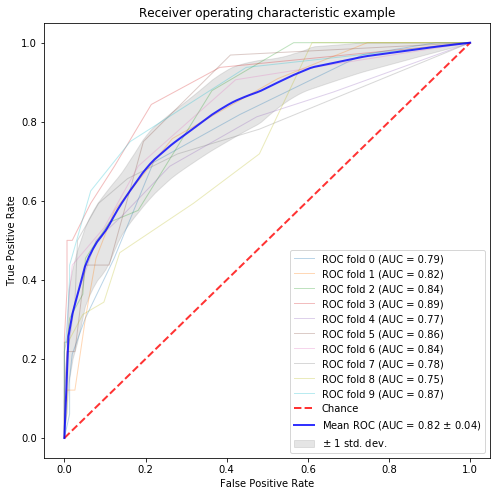

In [83]:
X = matrix
y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

### TF-IDF

In [84]:
tfidf_list = tf_idf_scored_df.query(' score > 0.001 ').feature.unique().tolist()
corpus_data["tfidf_base_list"] = list(map(lambda text: " ".join(list(set(text.split(" ") ) & set(tfidf_list))) , corpus_data.text_wakati))

In [85]:
# word count feature
countvector = CountVectorizer()
matrix = countvector.fit_transform(corpus_data.tfidf_base_list)
countvector.get_feature_names()[:10]

['bs', 'catv', 'cs', 'ih', 'isdn', 'it', 'lan', 'tv', 'way', 'wic']

234


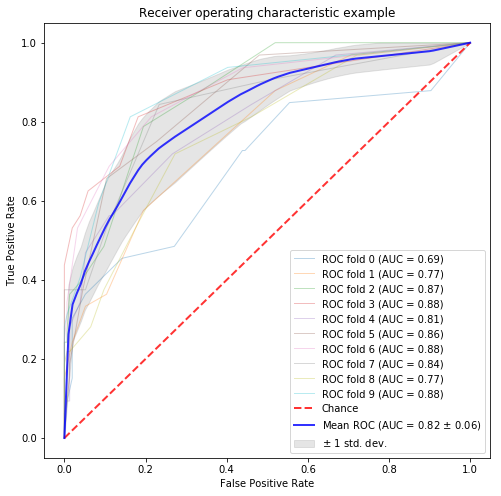

In [86]:
X = matrix
y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

### PMI

In [87]:
pmi_list = pmi_scored_df.query(' score > 0.001 ').feature.unique().tolist()
corpus_data["pmi_base_list"] = list(map(lambda text: " ".join(list(set(text.split(" ") ) & set(pmi_list))) , corpus_data.text_wakati))

In [88]:
# word count feature
countvector = CountVectorizer()
matrix = countvector.fit_transform(corpus_data.pmi_base_list)
countvector.get_feature_names()[:10]

['bs', 'catv', 'cs', 'isdn', 'it', 'lan', 'tv', 'ごみ', 'インターネット', 'インターホン']

158


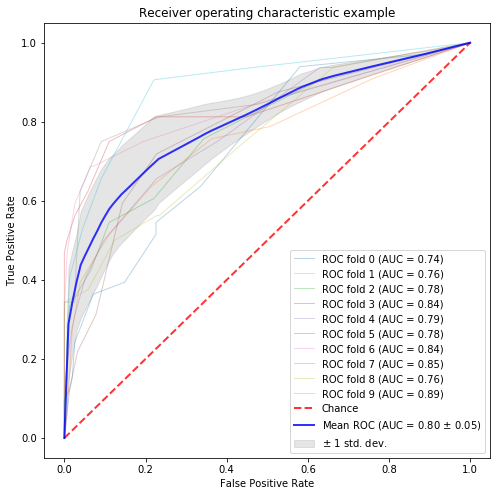

In [89]:
X = matrix
y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

### SOA

In [90]:
soa_list = soa_scored_df.query(' score > 0.2 ').feature.unique().tolist()
corpus_data["soa_base_list"] = list(map(lambda text: " ".join(list(set(text.split(" ") ) & set(soa_list))) , corpus_data.text_wakati))

In [91]:
# word count feature
countvector = CountVectorizer()
matrix = countvector.fit_transform(corpus_data.soa_base_list)
countvector.get_feature_names()[:10]

['bs', 'catv', 'cs', 'ih', 'ii', 'isdn', 'it', 'lan', 'tv', 'way']

217


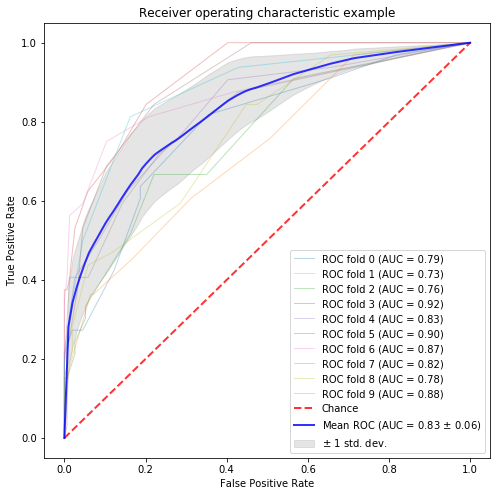

In [92]:
X = matrix
y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

### BNS

In [93]:
bns_list = bns_scored_df.query('  score > 0.1 ').feature.unique().tolist()
corpus_data["bns_base_list"] = list(map(lambda text: " ".join(list(set(text.split(" ") ) & set(bns_list))) , corpus_data.text_wakati))

In [94]:
# word count feature
countvector = CountVectorizer()
matrix = countvector.fit_transform(corpus_data.bns_base_list)
countvector.get_feature_names()[:10]

['aed', 'bs', 'cs', 'ii', 'isdn', 'it', 'lan', 'tv', 'way', 'wic']

247


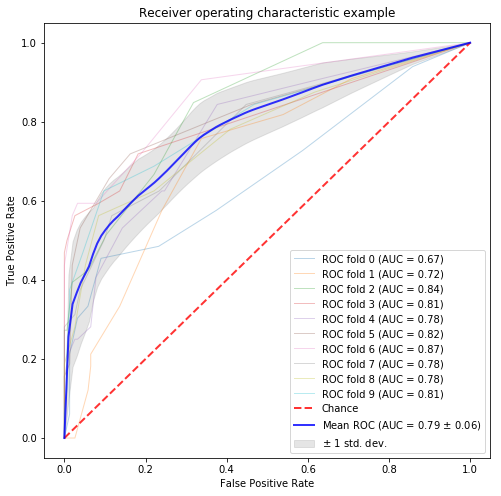

In [95]:
X = matrix
y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

## Conclusion
SOA won

# Clustering/TopicModel/Embeddings
+ BoWのデータに対してk-means
 + 標準化してから。

### Clustering

In [96]:
from sklearn.feature_extraction.text import CountVectorizer

# word count feature
countvector = CountVectorizer(min_df=0.01, max_df=0.90)
matrix = countvector.fit_transform(corpus_data.text_wakati)
countvector.get_feature_names()[:10]

['bs', 'catv', 'cs', 'ih', 'isdn', 'it', 'lan', 'ldk', 'tv', 'wic']

In [97]:
from sklearn import preprocessing

In [98]:
# 標準化
my_scalar = preprocessing.StandardScaler()
my_scalar.fit(pd.DataFrame(matrix.toarray()))
matrix_std = my_scalar.transform(pd.DataFrame(matrix.toarray()))

In [99]:
from sklearn.cluster import  KMeans, MiniBatchKMeans

n_clusters = 15

kmeans = KMeans(n_clusters=n_clusters)
minibatch = MiniBatchKMeans(n_clusters=n_clusters)

In [100]:
%time kmeans.fit(matrix_std.transpose())

CPU times: user 821 ms, sys: 87.9 ms, total: 909 ms
Wall time: 734 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [101]:
kmeans.cluster_centers_.transpose().shape

(1864, 15)

In [102]:
%time minibatch.fit(matrix_std.transpose())

CPU times: user 311 ms, sys: 34.9 ms, total: 346 ms
Wall time: 214 ms


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=15,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [103]:
minibatch.cluster_centers_.transpose().shape

(1864, 15)

15


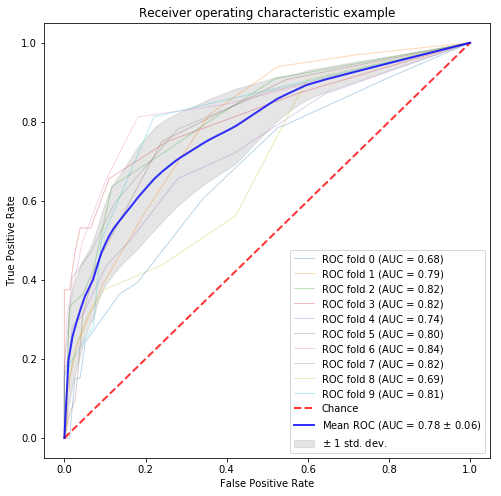

In [104]:
X = kmeans.cluster_centers_.transpose()
y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

15


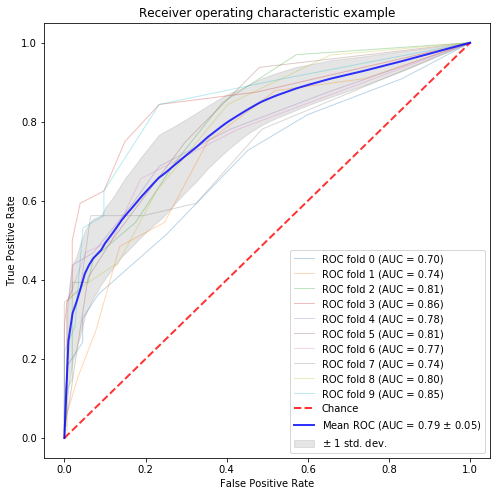

In [105]:
X = minibatch.cluster_centers_.transpose()
y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

### TopicModels

In [106]:
from gensim import corpora, models
import  gensim
import pickle

# データフレームのテキストデータをもとに、gensimで読み込み可能なフォーマットに変換するための関数
def nested_list(strings):
    words = strings.split(" ")
    return words

# トピック割合を格納するためのデータフレームを作成する関数
def making_topic_detaframe(integer, n):
    topic_table = pd.DataFrame(index=n.index)
    for topic_number in range(integer):
        column_name = "topic" + str(topic_number)
        topic_table[column_name] = 0
    return topic_table

# トピック割合を格納する関数
def topic_ratio_extract(corpus, topic_table):
    n_topic = len(topic_table.columns)
    i = 0
    for bow in corpus:
        t = lda.get_document_topics(bow)
        
        for each_topic in t:
            for topic_id in range(n_topic):
                if each_topic[0] == topic_id:
                    topic_table.iloc[i, topic_id]  = each_topic[1]
                
        i = i + 1
    return topic_table
 

corpus_data_filtered = corpus_data.query(' text_wakati !="" ').reset_index(drop=True)
corpus_data_filtered["text_wakati_fixed"] = list(map(lambda text:nested_list(text) ,corpus_data_filtered.text_wakati))

dictionary = gensim.corpora.Dictionary(corpus_data_filtered["text_wakati_fixed"])
dictionary.save_as_text('text.dict')

corpus = [dictionary.doc2bow(doc) for doc in corpus_data_filtered["text_wakati_fixed"]]
gensim.corpora.MmCorpus.serialize('text.mm', corpus)

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

with open('corpus_tfidf.dump', mode='wb') as f:
    pickle.dump(corpus_tfidf, f)


30


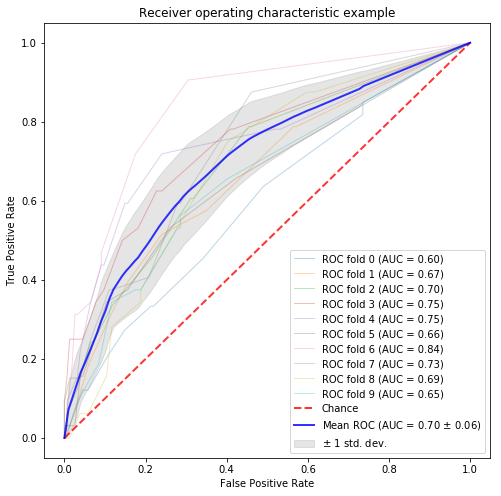

In [107]:
the_number_of_topic = 30

lda = gensim.models.ldamodel.LdaModel(
                            corpus=corpus,
                            alpha='asymmetric', 
                            eta = 'auto',
                            num_topics=the_number_of_topic,
                            id2word=dictionary,
                            random_state=123
)

# トピックの数に応じたデータフレームを作成
topic_table = making_topic_detaframe(the_number_of_topic, corpus_data_filtered)
# 推定したトピックごとの文書ごとの確率を格納
topic_table = topic_ratio_extract(corpus, topic_table)
# 元データとトピックテーブルを結合
corpus_data_filtered_with_topic = pd.concat([corpus_data_filtered, topic_table], axis=1)
# 実数に変換
corpus_data_filtered_with_topic[list(topic_table.columns)] = corpus_data_filtered_with_topic[list(topic_table.columns)].astype("float")


X = corpus_data_filtered_with_topic.filter(regex="topic").values
y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

### Embeddings
+ word2vecを推定し、単語に対して分散表現を足し算し平均を取る。
+ TF-IDF上位単語に対して分散表現を足し算し平均を取る。

In [45]:
import gensim.models.keyedvectors as word2vec_for_txt

In [46]:
# 少し時間がかかる
model_fasttext = word2vec_for_txt.KeyedVectors.load_word2vec_format('../../../../Downloads/model.vec', binary=False)

In [47]:
w2v_fasttext = {w: vec for w, vec in zip(model_fasttext.wv.index2word, model_fasttext.wv.syn0)}

#### 分散表現の合計値

300


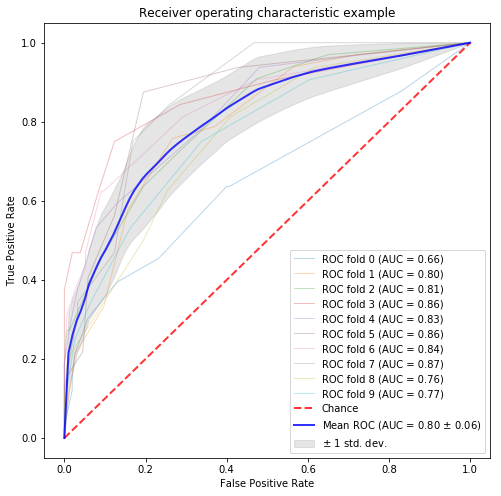

In [111]:
X = [token.split(" ") for token in corpus_data.text_wakati]
X = np.array([ np.sum([w2v_fasttext[w] for w in words if w in w2v_fasttext] \
                        or [np.zeros(next(iter(w2v_fasttext.values())).size)], axis=0) for words in X])

y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

#### 分散表現の平均値

300


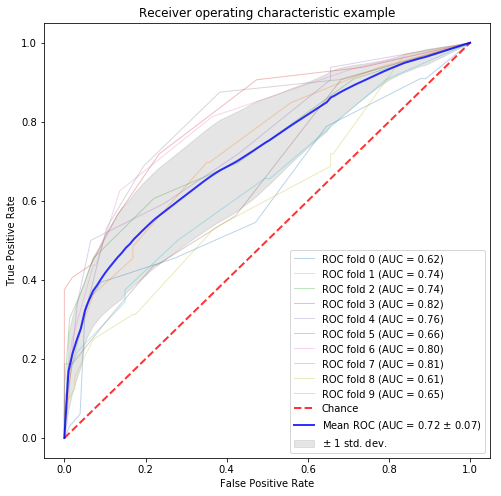

In [112]:
X = [token.split(" ") for token in corpus_data.text_wakati]
X = np.array([ np.mean([w2v_fasttext[w] for w in words if w in w2v_fasttext] \
                        or [np.zeros(next(iter(w2v_fasttext.values())).size)], axis=0) for words in X])

y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

#### 分散表現のTF-IDF平均値

300


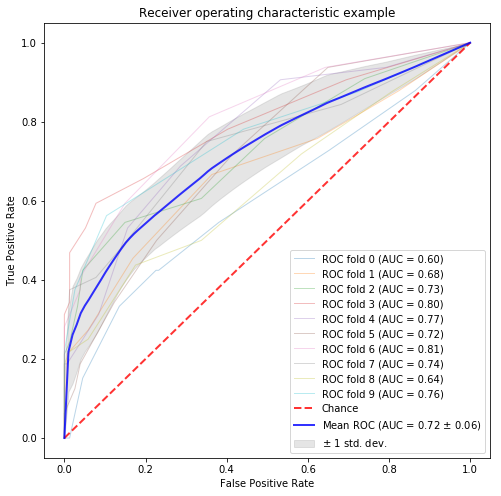

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

# TF-IDF値の計算
tfidf = TfidfVectorizer()
tfidf.fit(corpus_data.text_wakati)
max_idf = max(tfidf.idf_)

# TF-IDFの値を重み付けの係数として格納
word2weight = None
word2weight = defaultdict(lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

# 分散表現の抽出
X = [token.split(" ") for token in corpus_data.text_wakati]
X = np.array([np.mean([w2v_fasttext[w] * word2weight[w] for w in words if w in w2v_fasttext] \
                      or [np.zeros(next(iter(w2v_fasttext.values())).size)], axis=0) for words in X ])

y = corpus_data.designer_flag.values

n_samples, n_features = X.shape
print(n_features)

random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)

# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

# Similarity

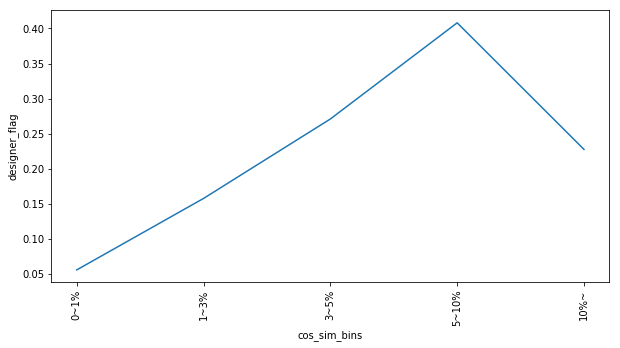

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

designer_definition = "デザイナーズ物件というと、連想されがちなのが「コンクリート打ちっぱなしの外壁」に代表されるスタイリッシュなデザインの建物。\
                                        でも、それだけではありません。全く間仕切りがないワンルーム、螺旋階段が部屋の中にある部屋など、\
                                        普通の物件では考えられない設備やデザインが魅力です。また、キッチンが部屋の真ん中に配置されていたり、\
                                        バスやトイレがガラス張りであったり、洗濯機や電子レンジを収める収納スペースで生活感を出さない構造であったりすることも。\
                                        インテリアや家具までレイアウトされている部屋が多いのも特徴です。こうした一風変わった造りは、\
                                        デザイナーや建築家のこだわりやコンセプトが反映されています。そのため、デザイナーズ物件は建築家やデザインの\
                                        「作品」と言うこともできます。そうした作品に住むことは憧れであり、ある種のステイタスと言えるでしょう。"
designer_definition_wakati = nouns_extract(designer_definition) 


text_list = list(set(corpus_data.text_wakati))
text_list.extend(designer_definition_wakati )

# TF-IDFの計算
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(text_list) # これで更新

# 類似度の計算
corpus_data["cos_sim"] = list(map(lambda number: cosine_similarity(vectorizer.transform([corpus_data.text_wakati[number]]),
                                                                                                                          vectorizer.transform([designer_definition_wakati]))[0][0] ,
                                                                                                                          range(corpus_data.index.size)))

bins = [0.00, 0.01, 0.03,0.05, 0.10,1.0]
labels=["0~1%", "1~3%", "3~5%", "5~10%", "10%~"]
corpus_data["cos_sim_bins"] = pd.cut(corpus_data.cos_sim, bins=bins, labels=labels, include_lowest=True)

df = corpus_data.groupby("cos_sim_bins")[["designer_flag"]].mean().reset_index()
ax = df.designer_flag.plot(xticks=df.index, rot=90, figsize=(10,5))
ax.set_xticklabels(df.cos_sim_bins);
ax.set_ylabel("designer_flag");
ax.set_xlabel("cos_sim_bins");

## References
+ 【python】sklearnのCountVectorizerの使い方  
https://www.haya-programming.com/entry/2018/02/25/044525

+ neologdn 0.4  
https://pypi.org/project/neologdn/

+ テキストデータで特徴量選択をする  
https://qiita.com/Kensuke-Mitsuzawa/items/48785d502a569a1ff862

+ models.ldamodel – Latent Dirichlet Allocation  
https://radimrehurek.com/gensim/models/ldamodel.html

+ Receiver Operating Characteristic (ROC) with cross validation  
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html